In [1]:
# Graficos y visualizaciones
import matplotlib.pyplot as plt
import plotly.express as px

# Liberias para manejo de datos
import pandas as pd

# Liberias estandar
import time
import os

In [2]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [10]:
Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'

Fdatos2021 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2021.csv'
Fdatos2020 = f'{path_base}/Archivos/Inicial/REPORTE_SGD_2020.csv'

In [3]:
# Realiza un grafico de dispersion (Tipo = 1) o boxplit (Tipo = 2)
def Grafico(df,filename,tipo):    
    x = df.index
    y = df['dato']   
    
    if tipo==1:
        plt.clf()
        plt.scatter(x=x,y=y, alpha=0.1)
    if tipo==2:
        plt.clf()
        plt.boxplot(x=y)
        
    plt.xlabel("Indices")
    plt.ylabel("Precipitacion (mm/h)")
    plt.title(f"{filename.split('/')[-1][:-4]}")
    plt.axhline(y=y.quantile(0.99), color='r', linestyle='-')
    
    plt.savefig(filename)
    plt.clf()
    #plt.show()

    return True

In [28]:
# Crea una carpeta (newDir) en path
def crearDir(path, newDir):
    try:
        pathT = os.path.join(path, newDir)
        os.mkdir(pathT)
        return pathT
    except FileExistsError:
        return pathT       
    except Exception as e:
        print(f"No se pudo crear el directorio: {newDir}")
        print(f'Path base: {path}')
        print(f'Nuevo    : {newDir}')        
        print(str(e))
        return None

In [31]:
#Por cada estacion se hallara:
#- Cantidad de datos,- Promedio,- Varianza,- Valor min ,- Valor max
#- Fecha minima,- Fecha Maxima,- Cantidad de datos atipicos (Mayores a 99%)
#- Cantidad de NA,- Cantidad de ceros
#- Cantidad de malos, conformes y dudosos
#Graficos
#- Boxplot,- Dispersion

# Si existe listDir, obtendra los datos de precipitacion en esta lista,
# caso contrario usara lo definido en dfDatos
def resumenStats(path_base,estacionesF,dfDatos,year,grafico=0, listDir=''):       
    stations = pd.read_csv(estacionesF)
    
    if listDir:
        listDF = []
        for file in listDir:
            listDF.append(pd.read_csv(file,encoding='latin-1'))
        datos = pd.concat(listDF, ignore_index=True)           
        
    else:
        datos = dfDatos   
        
    start_time = time.time() 
    resultado = []
    
    #Auxiliares    
    total = len(stations.index)
    completados = 1 
    
    path_plot = crearDir(f'{path_base}/Archivos/Reportes/Plots/', year)

    #Por cada estacion se realizara lso graficos
    for i in stations.index:    
        station = stations['ESTACION'][i]
        code = stations['CODE'][i]
        LON = stations['LON'][i]
        LAT = stations['LAT'][i]
        ALT = stations['ALT'][i]

        tempDato = datos.loc[datos['NOMBRE']==station]    
        cantNA = tempDato.loc[tempDato['PRECIPITACION'].isna()].count()[0]

        #Eliminamos todos los NA antes de realizar las estadisticas        
        tempDato = tempDato.dropna(axis='index',subset=['PRECIPITACION'])   
        
        
        cantC02 = tempDato.loc[tempDato['FLAG'].isin(['C0000002'])].count()[0]
        cantC01 = tempDato.loc[tempDato['FLAG'].isin(['C0000001'])].count()[0] 
        cantM01 = tempDato.loc[tempDato['FLAG'].isin(['M0000001','M0000001, M0110302','M0110302'])].count()[0]
        cantM02 = tempDato.loc[tempDato['FLAG'].isin(['M0000002','DIM00001'])].count()[0]
        cantD01 = tempDato.loc[tempDato['FLAG'].isin(['D0220301','D0230301','D0230303'])].count()[0]
        
        #Eliminamos los valores valores mayor a 401 o menor a 0
        tempDato = tempDato[tempDato['PRECIPITACION']<=401]
        tempDato = tempDato[tempDato['PRECIPITACION']>=0]
    
        

        stats = tempDato['PRECIPITACION'].describe()
        stats = stats.to_dict()    
        fmin = tempDato['FECHA'].min()
        fmax = tempDato['FECHA'].max()    
        stats['FechaMax'] = fmax
        stats['count'] = int(stats['count'])
        stats['FechaMin'] = fmin    
        stats['Nombre'] = station
        stats['Codigo'] = code
        stats['ceros'] = tempDato.loc[tempDato['PRECIPITACION']==0].count()[0]
        stats['NA'] = cantNA
        
        stats['cantC02'] = cantC02
        stats['cantC01'] = cantC01
        stats['cantM01'] = cantM01
        stats['cantM02'] = cantM02
        stats['cantD01'] = cantD01
        
        stats['75mayor'] = tempDato.loc[tempDato['PRECIPITACION']>stats['75%']].count()[0]
        stats['90mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.90)].count()[0]
        stats['90%'] =  tempDato['PRECIPITACION'].quantile(0.90)
        stats['99mayor'] = tempDato.loc[tempDato['PRECIPITACION']>tempDato['PRECIPITACION'].quantile(0.99)].count()[0]
        stats['99%'] =  tempDato['PRECIPITACION'].quantile(0.99)
        stats['LON'] = LON
        stats['LAT'] = LAT
        stats['ALT'] = ALT
        resultado.append(stats)
        
        if grafico:
            Grafico(tempDato,f'{path_plot}/{code}_scatter.png',1)   
            Grafico(tempDato,f'{path_plot}/{code}_box.png',2)   
        
        completados = completados +1
        if not completados % 50:
            progreso = completados/total*100
            f = '{0:.3g}'.format(progreso)
            print(f"Procesando - {f}%")
            

    print("Time taken: %.2fs" % (time.time() - start_time)) 
    
    #Borramos las estaciones que no tengan datos
    df = pd.DataFrame(resultado)
    df = df[df['count']!=0]

    #Guardamso las estadisticas
    df = df.astype({"count":int})
    df.to_csv(f'{path_base}/Archivos/Reportes/Datos/analisis_{year}.csv',index=False)
    print( f'Archiv: {path_base}/Archivos/Reportes/Datos/analisis_{year}.csv')

    return resultado


In [6]:
# Lista de los flags en orden de fase
listaFases = [
    'ND',    'C0000001',    'M0000001',    'M0000001, M0110302' ,    'M0110302',
    'D0210301',    'D0210302',    'D0210303',    'D0210304',    'D0220301',
    'D0230301',    'D0230302',    'D0230303',    'D0230304',    'C0000002',
    'DIM00001',    'M0000002', 'NC'
]
dfFases = pd.DataFrame({'FLAG' : listaFases})
dfFases = dfFases.reset_index().set_index('FLAG')

In [7]:
# Nombre de los archivos


df20 = pd.read_csv(Fdatos2020,encoding='latin-1')
df21 = pd.read_csv(Fdatos2021,encoding='latin-1')

# Unimos los dos años de precipitaciones en un solo DataFrame
dfPrecipitacion = pd.concat([df20,df21], ignore_index=True) 

In [8]:
#Revisamos la cantidad de datos por flag
dfFlag = dfPrecipitacion.groupby(['FLAG'], dropna = False).size().reset_index(name='Cantidad')
dfFlag['Fase'] = dfFlag['FLAG'].map(dfFases['index'])
dfFlag = dfFlag.sort_values(by=['Fase'])
dfFlag['porc%'] = dfFlag['Cantidad'] / dfFlag['Cantidad'].sum() * 100

dfFlag

,FLAG,Cantidad,Fase,porc%
10,ND,462645,0,13.272817
0,C0000001,2877873,1,82.563264
6,M0000001,17,2,0.000488
7,"M0000001, M0110302",5646,3,0.161978
9,M0110302,554,4,0.015894
2,D0220301,24744,9,0.709880
3,D0230301,21440,10,0.615092
4,D0230303,25826,12,0.740922
1,C0000002,58364,14,1.674404
5,DIM00001,2,15,0.000057


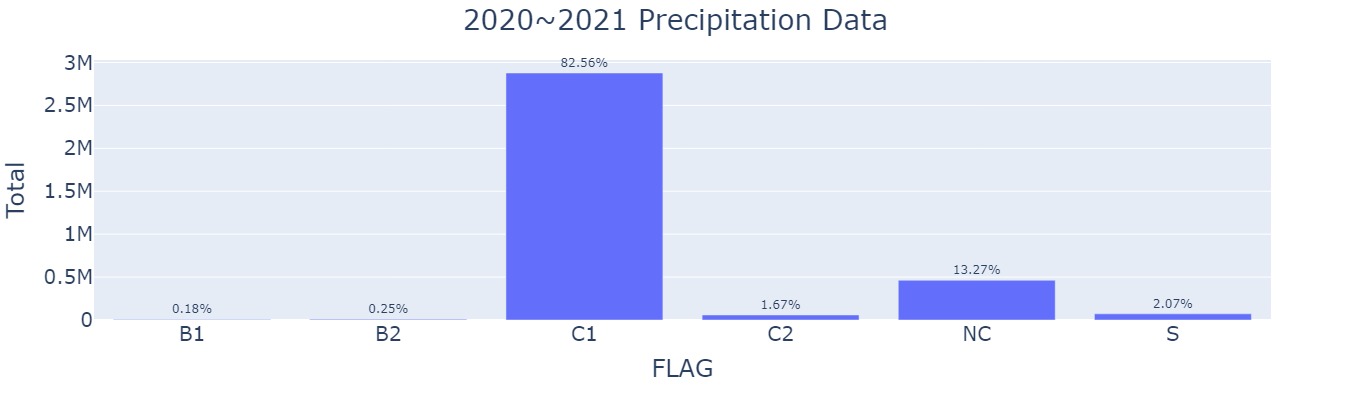

In [21]:
import plotly.express as px
_dfFlag = dfFlag.drop([6,5],axis=0)
#_dfFlag = dfFlag.drop([10,0,6,5,7,9],axis=0)
_dfFlag['FLAG'] = ['NC','C1','B1','B1','S','S','S','C2','B2'] #['ND','C01','M01','M01','DUD','DUD','DUD','C02','M02']
#_dfFlag['FLAG'] = ['DUD','DUD','DUD','C02','M02']
#['NC','C1','B1','B1','S','S','S','C2','B2']
_dfFlag = _dfFlag.set_index('FLAG')
_dfFlag = _dfFlag.groupby(lambda x: x, axis=0).sum()
_dfFlag['porc'] = _dfFlag['Cantidad'] / _dfFlag['Cantidad'].sum() * 100
#_dfFlag['text'] = (_dfFlag['Cantidad']/1000).apply(lambda x: '{0:1.3f}'.format(x)).astype(str) + 'K' + ' (' + _dfFlag['porc'].apply(lambda x: '{0:1.2f}%'.format(x)) + ')'
_dfFlag['text'] =  _dfFlag['porc'].apply(lambda x: '{0:1.2f}%'.format(x))
_dfFlag = _dfFlag.reset_index()



fig = px.bar(_dfFlag, y='Cantidad', x='FLAG',text=_dfFlag["text"])

fig.update_layout(
    title={'text' :"2020~2021 Precipitation Data ",
           'x':0.5,
           'xanchor': 'center'
          },
    xaxis_title="FLAG",
    yaxis_title="Total",
    
    font = {'size':20},
                 width=800, height=400
) 

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False,)
fig.show()

In [ ]:
# Eliminar malos en Etapa 1 ( orden de "listaFases")
eliminarFG = [0,1,2,3,4,9,10,12,15]
dfFlagManual = dfFlag[~dfFlag['Fase'].isin(eliminarFG)]

fig, ax = plt.subplots()
ax.barh(dfFlagManual['FLAG'], dfFlagManual['Cantidad'])
plt.xlabel('Cantidad')
plt.title('GRAFICO DE BARRAS PARA LOS FLAGS MANUALES')
plt.show()

dfFlagManual

In [ ]:
58364 / (58364+8547)

In [ ]:
dfFlagManual

In [ ]:
dfPrecipitacion.head(2)

In [ ]:
len(dfPrecipitacion['CODIGO'].unique())

In [ ]:
# Analizamos los datos M02

dfPrecipitacion[dfPrecipitacion['FLAG']=='M0000002']['PRECIPITACION'].hist(legend=True)
print(f"Total       : {len(dfPrecipitacion[dfPrecipitacion['FLAG']=='M0000002'])}")
print(f"Cantidad M01: {len(dfPrecipitacion[(dfPrecipitacion['FLAG']=='M0000002') & ((dfPrecipitacion['PRECIPITACION']>401) | (dfPrecipitacion['PRECIPITACION']<0))])}")
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Precipitacion de datos con Flag M02')
plt.show()
"""
fig = px.histogram(dfPrecipitacion[dfPrecipitacion['FLAG']=='M0000002'], x="PRECIPITACION")

fig.update_layout(
    title={'text' :"Histograma de precipitacion con flag M02",
           'x':0.5,
           'xanchor': 'center'
          },
    xaxis_title="Precipitaciones",
    yaxis_title="Cantidad"
)

fig.show()
"""

In [ ]:
# Analizamos los datos C02

dfPrecipitacion[dfPrecipitacion['FLAG']=='C0000002']['PRECIPITACION'].hist(legend=True)
print(f"Total       : {len(dfPrecipitacion[dfPrecipitacion['FLAG']=='C0000002'])}")
print(f"Cantidad M01: {len(dfPrecipitacion[(dfPrecipitacion['FLAG']=='C0000002') & ((dfPrecipitacion['PRECIPITACION']>401) | (dfPrecipitacion['PRECIPITACION']<0))])}")
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Precipitacion de datos con Flag C02')
plt.show()
"""
fig = px.histogram(dfPrecipitacion[dfPrecipitacion['FLAG']=='C0000002'], x="PRECIPITACION")

fig.update_layout(
    title={'text' :"Histograma de precipitacion con flag C02",
           'x':0.5,
           'xanchor': 'center'
          },
    xaxis_title="Precipitaciones",
    yaxis_title="Cantidad"
)

fig.show()
"""

In [ ]:
#dfFlagManual['M01'] = [64,173]
#dfFlagManual['FLAG'] = ['C02','M02']

In [ ]:
# Visualizamos lso datos M01 en C02
dfPrecipitacion[(dfPrecipitacion['FLAG']=='C0000002') & (dfPrecipitacion['PRECIPITACION']<0)]

In [14]:
#Realizaremos un resumen de los datos año 2020
#Grafico 0 = NO GRAFICO
#Grafico 1 = dispersion
#Grafico 2 = boxPLot
grafico = 0

#resultados = resumenStats(path_base,Festaciones,dfPrecipitacion,'Total',grafico)
#dfAnalisis = pd.read_csv(f'{path_base}/Archivos/Reportes/Datos/analisis_Total.csv')
#dfAnalisis

## LUEGO DE REALIZAR LA SIMULACION DE CONTROL DE CALIDAD ...

In [17]:
# Visualizamos
dsCompleto =pd.read_csv(fileV2, index_col=0)
dsCompleto.head(5)

,CODIGO,NOMBRE,FECHA,HORA,PRECIPITACION,FLAG,FLAGV2
0,4722A338,ACJANACO,01/01/2021,00:00:00,0.1,C0000001,C01
1,4722A338,ACJANACO,01/01/2021,01:00:00,0.0,C0000001,C01
2,4722A338,ACJANACO,01/01/2021,02:00:00,0.0,C0000001,C01
3,4722A338,ACJANACO,01/01/2021,03:00:00,0.0,C0000001,C01
4,4722A338,ACJANACO,01/01/2021,04:00:00,0.0,C0000001,C01


In [71]:
dsCompleto_MANUAL = dsCompleto[(dsCompleto['FLAGV2'].isin(['D01', 'D02'])) & (dsCompleto['FLAG'].isin(['C0000002', 'M0000002']))]
print(dsCompleto['FLAGV2'].unique())
print(dsCompleto['FLAG'].unique())

['C01' 'M01' 'ND' 'D01' 'D02' 'NC']
['C0000001' 'ND' 'D0230301' 'D0230303' 'C0000002' 'M0000001, M0110302'
 'D0220301' 'M0000002' 'M0110302' 'M0000001' 'DIM00001']


In [72]:
%%time
resultados_MANUAL = resumenStats(path_base,Festaciones,dsCompleto_MANUAL,'Total-F2',grafico)

Procesando - 15.5%
Procesando - 31%
Procesando - 46.4%
Procesando - 61.9%
Procesando - 77.4%
Procesando - 92.9%
Time taken: 2.89s
Archiv: C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Reportes/Datos/analisis_Total-F2.csv
CPU times: total: 2.8 s
Wall time: 2.9 s


In [73]:
_df =  pd.DataFrame(resultados_MANUAL)
_df

,count,mean,std,min,25%,50%,75%,max,FechaMax,FechaMin,...,cantM02,cantD01,75mayor,90mayor,90%,99mayor,99%,LON,LAT,ALT
0,200,2.033500,4.067907,0.1,0.2,0.5,2.6,36.3,31/12/2021,01/03/2021,...,0,0,49,20,4.64,2,18.811,-80.39788,-4.48047,116.0
1,109,1.108257,3.021746,0.1,0.1,0.2,0.6,24.9,26/11/2021,01/05/2021,...,0,0,26,11,1.78,2,11.772,-80.39014,-4.48956,116.0
2,581,1.928055,3.410823,0.1,0.2,0.6,2.2,34.6,31/10/2021,01/01/2021,...,2,0,142,58,4.90,6,15.880,-79.71077,-4.63776,2633.0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,0,NaN,-80.39898,-3.97972,143.0
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,0,NaN,-80.40182,-3.97594,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,0,NaN,-77.70762,-9.18553,2601.0
319,459,1.488453,1.551861,0.1,0.4,1.0,1.9,8.7,31/03/2021,01/03/2021,...,0,0,113,45,3.70,4,6.600,-70.08281,-13.88492,3873.0
320,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,0,NaN,-76.77167,-11.57833,2518.0
321,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,0,NaN,-76.15306,-11.83833,4319.0


In [74]:
dsCompleto_MANUAL.describe()

,PRECIPITACION
count,39516.000000
mean,1.938642
std,9.115502
min,0.010000
25%,0.200000
50%,0.600000
75%,1.800000
max,337.500000


In [76]:
len(dsCompleto_MANUAL),sum(dsCompleto_MANUAL['FLAG'].isin(['C0000002']))

(39516, 38793)

In [81]:
len(dsCompleto_MANUAL),sum(dsCompleto_MANUAL['PRECIPITACION']>5)

(39516, 2647)

In [83]:
38793/39516

0.9817036137260856

In [67]:
dsCompleto_MANUAL['FLAG'].unique()

array(['D0230301', 'D0230303', 'C0000002', 'M0000002', 'D0220301',
       'C0000001', 'M0110302', 'DIM00001'], dtype=object)

In [77]:
39516/99055*100

39.89298874362728

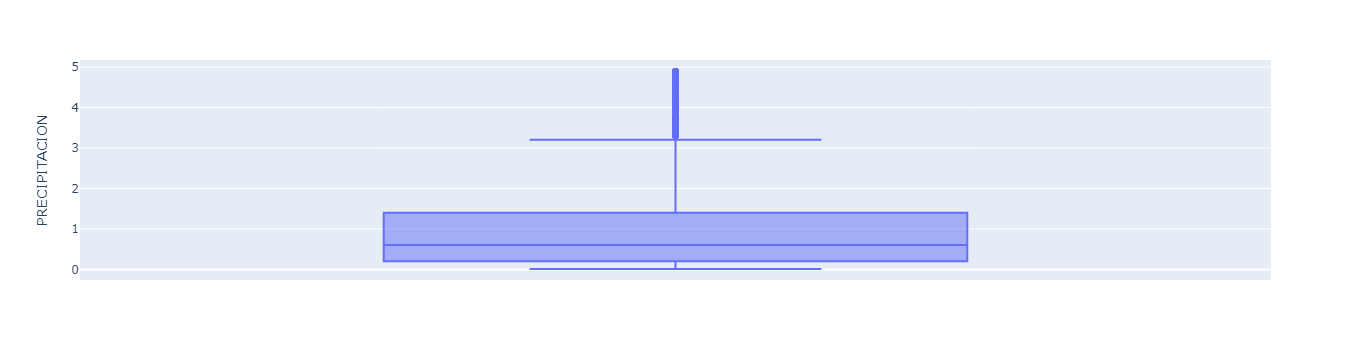

In [75]:
fig = px.box(dsCompleto_MANUAL[dsCompleto_MANUAL['PRECIPITACION']<5],  y="PRECIPITACION" )
#fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [ ]:
# Seleccionamos solo lso que vamos a usar (C02 y M02)
dsC02_V2 = dsCompleto[dsCompleto['FLAG']=='C0000002']
dsM02_V2 = dsCompleto[dsCompleto['FLAG']=='M0000002']
dsDUD_V2 = dsCompleto[dsCompleto['FLAG'].isin(['D0230301','D0230303','D0220301'])]

In [ ]:
dsCompleto['FLAGV2'].unique()

In [ ]:
_dsTemp = dsCompleto[dsCompleto['FLAGV2'].isin(['D01','D02'])]


dsC02_V2 = _dsTemp[_dsTemp['FLAG']=='C0000002']
dsM02_V2 = _dsTemp[_dsTemp['FLAG']=='M0000002']
dsDUD_V2 = _dsTemp[_dsTemp['FLAG'].isin(['D0230301','D0230303','D0220301'])]


In [ ]:
len(dsC02_V2) / len(_dsTemp) * 100 , len(dsM02_V2) / len(_dsTemp) * 100, len(dsDUD_V2) / len(_dsTemp) * 100

In [ ]:
len(dsM02_V2) / (len(dsC02_V2) + len(dsM02_V2)) * 100


In [ ]:
#Revisamos la cantidad de datos por flag
dfC2_FlagV2 = dsCompleto.groupby(['FLAGV2'], dropna = False).size().reset_index(name='Cantidad')
dfC2_FlagV2['porc'] = dfC2_FlagV2['Cantidad'] / dfC2_FlagV2['Cantidad'].sum() * 100
dfC2_FlagV2['text'] = (dfC2_FlagV2['Cantidad']/1000000).apply(lambda x: '{0:1.2f}'.format(x)).astype(str) + 'M' \
                        + ' (' + dfC2_FlagV2['porc'].apply(lambda x: '{0:1.2f}%'.format(x)) + ')'


fig = px.bar(dfC2_FlagV2, y='Cantidad', x='FLAGV2', text=dfC2_FlagV2["text"])

fig.update_layout(
    title={'text' :"Distribucion de FLAG V2 en el dataset",
           'x':0.5,
           'xanchor': 'center'
          },
    xaxis_title="FLAG",
    yaxis_title="Cantidad"
)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

"""
dsC02_V2['FLAGV2'].hist(legend=True)
plt.title('nHISTOGRAMA DE FLAGS V2')
plt.show()

print('FLAGV2 para datos CONFORME MANUAL (C02)')
dfC2_FlagV2
"""

In [ ]:
dsCompletoMan = dsCompleto[dsCompleto['FLAG'].isin(['C0000002','M0000002'])]
dsCompletoMan = dsCompletoMan[dsCompletoMan['FLAGV2'].isin(['D01','D02'])]
#dsCompletoMan
dsCompletoFlag = dsCompletoMan.groupby(['FLAG'], dropna = False).size().reset_index(name='Cantidad')

dsCompletoFlag['FLAG'] = ['C02','M02']
dsCompletoFlag['Version'] = 'V2'
#dsCompletoFlag

dfFlagManual = _dfFlag[_dfFlag['FLAG'].isin(['C02','M02'])]
dfFlagManual['Version'] = 'V1'
dfFlagManual = dfFlagManual[['FLAG','Cantidad','Version']]
#dfFlagManual

In [ ]:
_dfFlagManual = pd.concat([dfFlagManual,dsCompletoFlag], axis=0)
_dfFlagManual['text'] = (_dfFlagManual['Cantidad']/1000).apply(lambda x: '{0:1.2f}'.format(x)).astype(str) + 'K'

fig = px.bar(_dfFlagManual, y='Cantidad', x='FLAG', text='text', color='Version', barmode='group')

fig.update_layout(
    title={'text' :"Flags manuales V1 y V2",
           'x':0.5,
           'xanchor': 'center'
          },
    xaxis_title="FLAG",
    yaxis_title="Cantidad"
)

fig.show()

In [ ]:
# Analizamos flag V2 para C02
dsC02_C01 = dsC02_V2[(dsC02_V2['FLAGV2']=='C01')]
dsC02_C01['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> C01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()

dsC02_D01 = dsC02_V2[(dsC02_V2['FLAGV2'].isin(['D01','D02']))]
dsC02_D01['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> D01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsC02_NC = dsC02_V2[(dsC02_V2['FLAGV2']=='NC')]
dsC02_NC['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> NC')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsC02_M01 = dsC02_V2[(dsC02_V2['FLAGV2']=='M01')]
dsC02_M01['PRECIPITACION'].hist(legend=True)
plt.title('C0000002 -> M01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()

In [ ]:
#Revisamos la cantidad de datos por flag
dfM2_FlagV2 = dsM02_V2.groupby(['FLAGV2'], dropna = False).size().reset_index(name='Cantidad')
dfM2_FlagV2['porc%'] = dfM2_FlagV2['Cantidad'] / dfM2_FlagV2['Cantidad'].sum() * 100


dsM02_V2['FLAGV2'].hist(legend=True)
plt.title('nHISTOGRAMA DE FLAGS V2')
plt.show()

print('FLAGV2 para datos CONFORME MANUAL (M02)')
dfM2_FlagV2

In [ ]:
# Analizamos flag V2 para M02
dsM02_C01 = dsM02_V2[(dsM02_V2['FLAGV2']=='C01')]
dsM02_C01['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> C01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()

dsM02_D01 = dsM02_V2[(dsM02_V2['FLAGV2'].isin(['D01','D02']))]
dsM02_D01['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> D01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsM02_NC = dsM02_V2[(dsM02_V2['FLAGV2']=='NC')]
dsM02_NC['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> NC')
plt.xlabel('Valor')
plt.ylabel('Cantidad')

plt.show()

dsM02_M01 = dsM02_V2[(dsM02_V2['FLAGV2']=='M01')]
dsM02_M01['PRECIPITACION'].hist(legend=True)
plt.title('M0000002 -> M01')
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.show()